In [1]:
import psutil
import GPUtil
import time

def check_system_usage():
    # Start time
    start_time = time.time()

    # CPU usage
    cpu_usage = psutil.cpu_percent()

    # Memory usage
    memory_info = psutil.virtual_memory()
    memory_usage = memory_info.percent

    # GPU usage
    gpus = GPUtil.getGPUs()
    gpu_info = [(gpu.id, gpu.name, gpu.load*100, gpu.memoryUsed, gpu.memoryTotal) for gpu in gpus]

    # End time
    end_time = time.time()
    execution_time = end_time - start_time

    #Print results
    print(f"CPU usage: {cpu_usage}%")
    print(f"Memory usage: {memory_usage}%")
    for gpu in gpu_info:
        print(f"GPU {gpu[0]}: {gpu[1]}, {gpu[2]}% load, {gpu[3]}MB used of {gpu[4]}MB")
        print(f"Execution time: {execution_time} seconds")


In [2]:
# # Custom code to get the metrics
# import psutil
# import time
# import csv
# import os

# # Function to get system metrics
# def get_system_metrics():
#     metrics = {}
#     metrics['cpu_usage'] = psutil.cpu_percent(interval=1)
#     metrics['cpu_memory_usage'] = psutil.virtual_memory().percent
#     metrics['overall_memory_usage'] = psutil.virtual_memory().used / (1024 ** 3)  # in GB

#     # Check if GPU is available and get GPU metrics
#     try:
#         import GPUtil
#         gpus = GPUtil.getGPUs()
#         if gpus:
#             gpu = gpus[0]
#             metrics['gpu_usage'] = gpu.load * 100
#             metrics['gpu_memory_usage'] = gpu.memoryUtil * 100
#         else:
#             metrics['gpu_usage'] = None
#             metrics['gpu_memory_usage'] = None
#     except ImportError:
#         metrics['gpu_usage'] = None
#         metrics['gpu_memory_usage'] = None

#     return metrics

# # Function to log metrics to a CSV file
# def log_metrics_to_csv(metrics, filename='system_metrics.csv'):
#     file_exists = os.path.isfile(filename)
    
#     with open(filename, mode='a', newline='') as file:
#         writer = csv.DictWriter(file, fieldnames=metrics.keys())
        
#         if not file_exists:
#             writer.writeheader()
        
#         writer.writerow(metrics)




################ Try 2
import psutil
import subprocess
import time
import csv
from datetime import datetime
from threading import Thread

def get_gpu_usage():
    try:
        gpu_info = subprocess.check_output(
            ["nvidia-smi", "--query-gpu=utilization.gpu,memory.used,memory.total", "--format=csv,noheader,nounits"],
            encoding="utf-8"
        ).strip()
        gpu_usage, mem_used, mem_total = map(int, gpu_info.split(", "))
        return gpu_usage, mem_used, mem_total
    except subprocess.CalledProcessError:
        return None, None, None

def get_system_metrics():
    metrics = {}
    metrics['cpu_usage'] = psutil.cpu_percent(interval=1)
    metrics['cpu_memory_usage'] = psutil.virtual_memory().percent
    metrics['overall_memory_usage'] = psutil.virtual_memory().used / (1024 ** 3)  # in GB

    gpu_usage, gpu_mem_used, gpu_mem_total = get_gpu_usage()
    metrics['gpu_usage'] = gpu_usage
    metrics['gpu_memory_used'] = gpu_mem_used
    metrics['gpu_memory_total'] = gpu_mem_total
    metrics['Num_of_epochs'] = "25"
    metrics['Sample_rows'] = "25000"

    return metrics



Non-A100 GPU detected, using math or mem efficient attention if input tensor is on cuda
torch.Size([32, 512])
torch.Size([16, 256])
torch.Size([64, 128])


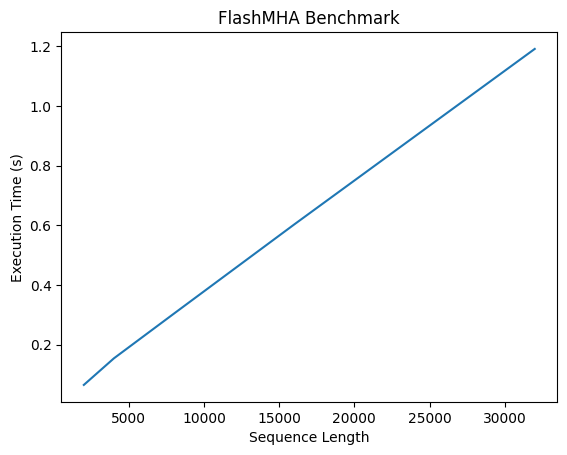

In [3]:
import copy
import gc
import json
import os
from pathlib import Path
import sys
import time
import traceback
#from typing import List, Tuple, Dict, Union, Optional
import warnings

import torch
from anndata import AnnData
import scanpy as sc
import scvi
import numpy as np
import wandb
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchtext.vocab import Vocab
from torchtext._torchtext import (
    Vocab as VocabPybind,
)
import pandas as pd
import scipy.sparse as sp
from sklearn import preprocessing

sys.path.insert(0, "../")
from scgpt import prepare_data, prepare_dataloader, define_wandb_metrcis, evaluate, eval_testdata, train
from scgpt.tokenizer import tokenize_and_pad_batch
from scgpt.model import MultiOmicTransformerModel

import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.tokenizer import random_mask_value
from scgpt.loss import (
    masked_mse_loss,
    masked_relative_error,
    criterion_neg_log_bernoulli,
)
from scgpt.preprocess import Preprocessor
from scgpt.utils import set_seed, category_str2int, eval_scib_metrics

sc.set_figure_params(figsize=(4, 4))
os.environ["KMP_WARNINGS"] = "off"
warnings.filterwarnings('ignore')


In [4]:
hyperparameter_defaults = dict(
    task = 'multiomic',
    seed=42,
    dataset_name="Flu", # Dataset name
    do_train=True, # Flag to indicate whether to do update model parameters during training
    load_model="./save/scGPT_human", # Path to pre-trained model
    freeze = False, #freeze
    GEP=True, # Gene expression modelling
    GEPC=True, # Gene expression modelling for cell objective
    CLS=False,
    ESC=False,
    DAR = True, # DAR objective weight for batch correction
    DSBN = False,  # Domain-spec batchnorm,
    mask_ratio=0.4, # Default mask ratio
    explicit_zero_prob = False,  # whether explicit bernoulli for zeros
    ecs_thres=0,  # Elastic cell similarity objective, 0.0 to 1.0, 0.0 to disable
    dab_weight=1.0,
    use_batch_labels = True,
    use_mod = True,
    per_seq_batch_sample = False,
    epochs=5,   #25 Default number of epochs for fine-tuning         #MODIFY
    input_layer_key = "X_binned", # Default expression value binning in data pre-processing
    n_bins= 51,    # Default number of bins for value binning in data pre-processing
    n_hvg = 1200,  # Default number of highly variable genes
    n_hvp = 4000,
    max_seq_len = 4001, # # Default n_hvg+1
    lr=5e-4, #1e-3, # Default learning rate for fine-tuning                   #MODIFY
    batch_size= 64, #16, # Default batch size for fine-tuning               #MODIFY
    layer_size=512,
    nlayers=4,
    nhead=8, # if load model, batch_size, layer_size, nlayers, nhead will be ignored
    dropout=0.2, # Default dropout rate during model fine-tuning
    schedule_ratio=0.95,  # Default rate for learning rate decay
    save_eval_interval=5, # Default model evaluation interval
    log_interval=100,  # Default log interval
    fast_transformer=True, # Default setting
    pre_norm=False, # Default setting
    amp=True,  # Default setting: Automatic Mixed Precision
    pad_token = "<pad>",
    mask_value = -1,
    pad_value = -2,
    include_zero_gene = False,
)

# Collecting metrics(custom script in chunk2)
chunk_name = "hyperparametrs_chunk3"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for hyperparametrs_chunk3 collected and logged successfully.


In [5]:
# Manually set the configuration
config = hyperparameter_defaults
print(config)

{'task': 'multiomic', 'seed': 42, 'dataset_name': 'Flu', 'do_train': True, 'load_model': './save/scGPT_human', 'freeze': False, 'GEP': True, 'GEPC': True, 'CLS': False, 'ESC': False, 'DAR': True, 'DSBN': False, 'mask_ratio': 0.4, 'explicit_zero_prob': False, 'ecs_thres': 0, 'dab_weight': 1.0, 'use_batch_labels': True, 'use_mod': True, 'per_seq_batch_sample': False, 'epochs': 5, 'input_layer_key': 'X_binned', 'n_bins': 51, 'n_hvg': 1200, 'n_hvp': 4000, 'max_seq_len': 4001, 'lr': 0.0005, 'batch_size': 64, 'layer_size': 512, 'nlayers': 4, 'nhead': 8, 'dropout': 0.2, 'schedule_ratio': 0.95, 'save_eval_interval': 5, 'log_interval': 100, 'fast_transformer': True, 'pre_norm': False, 'amp': True, 'pad_token': '<pad>', 'mask_value': -1, 'pad_value': -2, 'include_zero_gene': False}


In [6]:
def set_seed(seed):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

# Set the seed using the value from the config
set_seed(config['seed'])

In [7]:
# Settings for input and preprocessing
special_tokens = [config['pad_token'], "<cls>", "<eoc>"]

In [8]:
dataset_name = config['dataset_name']
save_dir = Path(f"./save/dev_{dataset_name}-{time.strftime('%b%d-%H-%M')}/")
save_dir.mkdir(parents=True, exist_ok=True)
print(f"save to {save_dir}")

save to save/dev_Flu-Nov28-11-48


In [9]:
logger = scg.logger
scg.utils.add_file_handler(logger, save_dir / "run.log")

In [10]:
if dataset_name == 'Flu':
    adata = sc.read("./data/flu_vacc_CITEseq_combinedassay.h5ad")
    adata = adata[:71122, :]
    adata.obs["celltype"] = adata.obs["celltype_joint"].astype(str).astype('category')
    adata.var["gene_name"] = adata.var.index.tolist()
    adata.var['feature_types'] = adata.var['features'].apply(lambda x: 'ADT' if '_PROT' in x else 'GEX')
    le = preprocessing.LabelEncoder()
    encoded_batch = le.fit_transform(adata.obs['batch'].values)
    adata.obs["batch_id"] =  encoded_batch
    adata.obs["str_batch"] = adata.obs["batch_id"].astype('category')
    adata_protein = adata[:, adata.var.feature_types.isin(['ADT'])].copy()
    adata_protein.var.index = ['p_' + i for i in adata_protein.var.index]
    adata = adata[:, adata.var.feature_types.isin(['GEX'])].copy()
    data_is_raw = False
    data_matrix = adata_protein.X.toarray() if issparse(adata_protein.X) else adata_protein.X
    adata_protein.X = data_matrix

# Collecting metrics(custom script in chunk2)
chunk_name = "datainjestion_chunk9"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for datainjestion_chunk9 collected and logged successfully.


In [11]:
#Check for Negative Values in Array ( Comment out next block for Scaling if Negative Values = 0 )

# data_matrix = adata.X.toarray() if issparse(adata.X) else adata.X
negative_values = data_matrix[data_matrix < 0]
print(f"Negative values: {negative_values}")
print(len(negative_values))

Negative values: [-0.33749851 -0.33009497 -0.02667652 ... -0.33563261 -0.06744269
 -0.42469102]
2062222


In [12]:
#Scaling the data to fix the Non-zero negatives
scaler = MinMaxScaler()
adata_protein.X = scaler.fit_transform(adata_protein.X)

# data_matrix = adata_protein.X.toarray() if issparse(adata_protein.X) else adata_protein.X

# #Log transformation
# adata_protein.X = np.log1p(adata_protein.X - adata_protein.X.min() + 1)

# # # Optionally, set negative values to zero
# data_matrix[data_matrix < 0] = 0    

# # # set negative values to positive
# data_matrix[data_matrix < 0] = np.abs(data_matrix[data_matrix < 0])

# adata_protein.X = data_matrix

# Collecting metrics(custom script in chunk2)
chunk_name = "datascaling_chunk11"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for datascaling_chunk11 collected and logged successfully.


In [13]:
if config['use_mod']:
    gene_rna_df = pd.DataFrame(index = adata.var.index.tolist())
    gene_rna_df['mod'] = 'RNA'
    gene_protein_df = pd.DataFrame(index = adata_protein.var.index.tolist())
    gene_protein_df['mod'] = 'Protein'
    gene_loc_df = pd.concat([gene_rna_df, gene_protein_df])
    gene_loc_df['mod'] = gene_loc_df['mod'].astype('category')

# Collecting metrics(custom script in chunk2)
chunk_name = "splitdf_chunk12"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for splitdf_chunk12 collected and logged successfully.


In [14]:
display((gene_loc_df['mod']))

RP11-34P13.7         RNA
AL627309.1           RNA
AP006222.2           RNA
RP4-669L17.10        RNA
RP11-206L10.3        RNA
                  ...   
p_CD80_PROT      Protein
p_CD86_PROT      Protein
p_CD183_PROT     Protein
p_CD34_PROT      Protein
p_CD20_PROT      Protein
Name: mod, Length: 19820, dtype: category
Categories (2, object): ['Protein', 'RNA']

In [15]:
#Cross-check gene set with the pre-trained model 
if config['load_model'] is not None:
    model_dir = Path(config['load_model'])
    model_config_file = model_dir / "args.json"
    model_file = model_dir / "best_model.pt"
    vocab_file = model_dir / "vocab.json"

    vocab = GeneVocab.from_file(vocab_file)
    for s in special_tokens:
        if s not in vocab:
            vocab.append_token(s)

    adata.var["id_in_vocab"] = [
        1 if gene in vocab else -1 for gene in adata.var["gene_name"]
    ]
    gene_ids_in_vocab = np.array(adata.var["id_in_vocab"])
    logger.info(
        f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
        f"in vocabulary of size {len(vocab)}."
    )
    old_vocab = vocab

# Set model parameters
embsize = config['layer_size']
nhead = config['nhead']
nlayers = config['nlayers']
d_hid = config['layer_size']

# Print the configuration to verify
print(f"Embedding size: {embsize}, Number of heads: {nhead}, Number of layers: {nlayers}, Hidden size: {d_hid}")

# Collecting metrics(custom script in chunk2)
chunk_name = "pre-trainedmode_chunk14"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

scGPT - INFO - match 17131/19733 genes in vocabulary of size 60697.
Embedding size: 512, Number of heads: 8, Number of layers: 4, Hidden size: 512
Metrics for pre-trainedmode_chunk14 collected and logged successfully.


In [16]:
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=1,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=data_is_raw,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=config['n_hvg'],  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=config['n_bins'],  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor(adata, batch_key=None)

check_system_usage()

# Collecting metrics(custom script in chunk2)
chunk_name = "preprocessing_gene_chunk15"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

scGPT - INFO - Filtering genes by counts ...
scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Normalizing total counts ...
scGPT - INFO - Subsetting highly variable genes ...
scGPT - WARNING - No batch_key is provided, will use all cells for HVG selection.
scGPT - INFO - Binning data ...
CPU usage: 3.3%
Memory usage: 24.0%
GPU 0: NVIDIA A10G, 0.0% load, 3215.0MB used of 23028.0MB
Execution time: 0.030205965042114258 seconds
Metrics for preprocessing_gene_chunk15 collected and logged successfully.


In [17]:
preprocessor_protein = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=0,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=False,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor=None,
    binning=config['n_bins'],  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)
preprocessor_protein(adata_protein, batch_key=None)

check_system_usage()

# Collecting metrics(custom script in chunk2)
chunk_name = "preprocessing_protein_chunk16"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

scGPT - INFO - Binning data ...
CPU usage: 3.2%
Memory usage: 24.0%
GPU 0: NVIDIA A10G, 0.0% load, 3215.0MB used of 23028.0MB
Execution time: 0.028218746185302734 seconds
Metrics for preprocessing_protein_chunk16 collected and logged successfully.


In [18]:
data_combined = np.concatenate([adata.layers["X_binned"], adata_protein.layers["X_binned"]], axis=1)
adata = AnnData(
    X=data_combined,
    obs=adata.obs,
    var=pd.DataFrame(index=adata.var_names.tolist() + adata_protein.var_names.tolist()),
    layers={"X_binned": data_combined,}
)
adata.var["gene_name"] = adata.var.index.tolist()


# Collecting metrics(custom script in chunk2)
chunk_name = "data_combine_chunk17"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for data_combine_chunk17 collected and logged successfully.


In [19]:
if config['per_seq_batch_sample']:
    # sort the adata by batch_id in advance
    adata_sorted = adata[adata.obs["batch_id"].argsort()].copy()

In [20]:
all_counts = (
    adata.layers[config['input_layer_key']].A
    if issparse(adata.layers[config['input_layer_key']])
    else adata.layers[config['input_layer_key']]
)
genes = adata.var["gene_name"].tolist()

celltypes_labels = adata.obs["celltype"].tolist()  # make sure count from 0
num_types = len(set(celltypes_labels))
celltypes_labels = np.array(celltypes_labels)

batch_ids = adata.obs["batch_id"].tolist()
num_batch_types = len(set(batch_ids))
batch_ids = np.array(batch_ids)

In [21]:
if config['use_mod']:
    mod_type = np.array([gene_loc_df.loc[g, 'mod'] for g in genes])
    vocab_mod = Vocab(VocabPybind(np.unique(gene_loc_df['mod']).tolist() + special_tokens, None))
    vocab_mod.set_default_index(vocab_mod["<pad>"])
    mod_type = np.array(vocab_mod(list(mod_type)), dtype=int)
    ntokens_mod = len(vocab_mod)
    print(mod_type)

[1 1 1 ... 0 0 0]


In [22]:
(
    train_data,
    valid_data,
    train_celltype_labels,
    valid_celltype_labels,
    train_batch_labels,
    valid_batch_labels,
) = train_test_split(
    all_counts, celltypes_labels, batch_ids, test_size=0.1, shuffle=True
)


In [23]:
num_of_non_zero_genes = [
    np.count_nonzero(train_data[i]) for i in range(train_data.shape[0])
]
print(f"max num of non_zero genes: {np.max(num_of_non_zero_genes)}")
print(f"min num of non_zero genes: {np.min(num_of_non_zero_genes)}")
print(f"average num of non_zero genes: {np.mean(num_of_non_zero_genes)}")
print(
    f"99% quantile num of non_zero genes: {np.quantile(num_of_non_zero_genes, 0.99)}"
)
print(f"max original values: {np.max(train_data)}")
print(
    f"average original non_zero values: {np.mean(train_data[np.nonzero(train_data)])}"
)
print(
    f"99% quantile original non_zero values: {np.quantile(train_data[np.nonzero(train_data)], 0.99)}"
)
print(f"num of celltypes: {num_types}")

max num of non_zero genes: 267
min num of non_zero genes: 90
average num of non_zero genes: 134.06642815854022
99% quantile num of non_zero genes: 200.0
max original values: 50
average original non_zero values: 25.120469505298516
99% quantile original non_zero values: 50.0
num of celltypes: 23


In [24]:
if config['load_model'] is None:
    vocab = Vocab(VocabPybind(genes + special_tokens, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)
else:
    pretrained_genes = [g for g in genes + special_tokens if g in old_vocab]
    new_genes = [g for g in genes + special_tokens if g not in old_vocab]
    gene_ids_pretrained = np.array(old_vocab(pretrained_genes), dtype=int)
    # https://discuss.pytorch.org/t/expand-an-existing-embedding-and-linear-layer-nan-loss-value/55670/2
    # Retrieve pretrained weights
    vocab = Vocab(VocabPybind(pretrained_genes + new_genes, None))
    vocab.set_default_index(vocab["<pad>"])
    gene_ids = np.array(vocab(genes), dtype=int)

In [25]:
tokenized_train = tokenize_and_pad_batch(
    train_data,
    gene_ids,
    max_len=config['max_seq_len'],
    vocab=vocab,
    pad_token=config['pad_token'],
    pad_value=config['pad_value'],
    append_cls=True,  # append <cls> token at the beginning
    include_zero_gene=config['include_zero_gene'],
    mod_type=mod_type if config['use_mod'] else None,
    vocab_mod=vocab_mod if config['use_mod'] else None,
)
tokenized_valid = tokenize_and_pad_batch(
    valid_data,
    gene_ids,
    max_len=config['max_seq_len'],
    vocab=vocab,
    pad_token=config['pad_token'],
    pad_value=config['pad_value'],
    append_cls=True,
    include_zero_gene=config['include_zero_gene'],
    mod_type=mod_type if config['use_mod'] else None,
    vocab_mod=vocab_mod if config['use_mod'] else None,
)
logger.info(
    f"train set number of samples: {tokenized_train['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_train['genes'].shape[1]}"
)
logger.info(
    f"valid set number of samples: {tokenized_valid['genes'].shape[0]}, "
    f"\n\t feature length: {tokenized_valid['genes'].shape[1]}"
)


# Collecting metrics(custom script in chunk2)
chunk_name = "tokenization_chunk24"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

scGPT - INFO - train set number of samples: 64009, 
	 feature length: 268
scGPT - INFO - valid set number of samples: 7113, 
	 feature length: 247
Metrics for tokenization_chunk24 collected and logged successfully.


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_dict = torch.load(model_file)
ntokens = len(vocab)  # size of vocabulary
model = MultiOmicTransformerModel(
    ntokens,
    embsize,
    nhead,
    d_hid, 
    nlayers,
    vocab=vocab,
    dropout=config['dropout'],
    pad_token=config['pad_token'],
    pad_value=config['pad_value'],
    do_mvc=config['GEPC'],
    do_dab=config['DAR'],
    use_batch_labels=config['use_batch_labels'],
    num_batch_labels=num_batch_types,
    domain_spec_batchnorm=config['DSBN'],
    n_input_bins=config['n_bins'],
    ecs_threshold=config['ecs_thres'],
    explicit_zero_prob=config['explicit_zero_prob'],
    use_fast_transformer=config['fast_transformer'],
    pre_norm=config['pre_norm'],
    use_mod=config['use_mod'],
    ntokens_mod=ntokens_mod if config['use_mod'] else None,
    vocab_mod=vocab_mod if config['use_mod'] else None,
)

with torch.no_grad():
    pretrained_emb_weights = model_dict['encoder.embedding.weight'][gene_ids_pretrained, :]
    model.encoder.embedding.weight.data[:len(pretrained_genes), :] = pretrained_emb_weights
    model.encoder.enc_norm.weight.data = model_dict['encoder.enc_norm.weight']
ntokens = len(vocab)

model.to(device)
#wandb.watch(model)
print(model)
check_system_usage()

# Collecting metrics(custom script in chunk2)
chunk_name = "TransformerModel_chunk25"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

MultiOmicTransformerModel(
  (encoder): GeneEncoder(
    (embedding): Embedding(1290, 512, padding_idx=1070)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (value_encoder): ContinuousValueEncoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (linear1): Linear(in_features=1, out_features=512, bias=True)
    (activation): ReLU()
    (linear2): Linear(in_features=512, out_features=512, bias=True)
    (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (batch_encoder): BatchLabelEncoder(
    (embedding): Embedding(2, 512)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (mod_encoder): BatchLabelEncoder(
    (embedding): Embedding(5, 512, padding_idx=2)
    (enc_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x FlashTransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamical

In [27]:
if config['GEP'] and config['GEPC']:
    criterion_gep_gepc = masked_mse_loss
if config['CLS']:
    criterion_cls = nn.CrossEntropyLoss()
if config['DAR']:
    criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=config['lr'], eps=1e-4 if config['amp'] else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=config['schedule_ratio'])
scaler = torch.cuda.amp.GradScaler(enabled=config['amp'])

# Collecting metrics(custom script in chunk2)
chunk_name = "chunk_26"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

Metrics for chunk_26 collected and logged successfully.


In [ ]:
#FineTuning
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None
batch_first = True
#define_wandb_metrcis()

for epoch in range(1, config['epochs'] + 1):
    epoch_start_time = time.time()
    train_data_pt, valid_data_pt = prepare_data(
        tokenized_train=tokenized_train, 
        tokenized_valid=tokenized_valid, 
        train_batch_labels=train_batch_labels,
        valid_batch_labels=valid_batch_labels,
        config=config,
        epoch=epoch,
        sort_seq_batch=config['per_seq_batch_sample'])
    
    train_loader = prepare_dataloader(
        train_data_pt,
        batch_size=config['batch_size'],
        shuffle=True,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config['per_seq_batch_sample']
    )
    valid_loader = prepare_dataloader(
        valid_data_pt,
        batch_size=config['batch_size'],
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
        per_seq_batch_sample=config['per_seq_batch_sample']
    )

    if config['do_train']:
        train(
            model=model,
            loader=train_loader,
            vocab=vocab,
            criterion_gep_gepc=criterion_gep_gepc if config['GEP'] and config['GEPC'] else None,
            criterion_dab=criterion_dab if config['DAR'] else None,
            criterion_cls=criterion_cls if config['CLS'] else None,
            scaler=scaler,
            optimizer=optimizer,
            scheduler=scheduler,
            device=device,
            config=config,
            logger=logger,
            epoch=epoch,
        )
    val_loss = evaluate(
        model=model,
        loader=valid_loader,
        vocab=vocab,
        criterion_gep_gepc=criterion_gep_gepc if config['GEP'] and config['GEPC'] else None,
        criterion_dab=criterion_dab if config['DAR'] else None,
        criterion_cls=criterion_cls if config['CLS'] else None,
        device=device,
        config=config,
        epoch=epoch
    )
    elapsed = time.time() - epoch_start_time
    logger.info("-" * 89)
    logger.info(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss {val_loss:5.4f} | "
    )
    logger.info("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        logger.info(f"Best model with score {best_val_loss:5.4f}")

    if epoch % config['save_eval_interval'] == 0 or epoch == config['epochs']:
        logger.info(f"Saving model to {save_dir}")
        torch.save(best_model.state_dict(), save_dir / f"model_e{best_model_epoch}.pt")

        # eval on testdata
        results = eval_testdata(
            model = best_model,
            adata_t = adata_sorted if config['per_seq_batch_sample'] else adata,
            gene_ids = gene_ids,
            vocab = vocab,
            config = config,
            logger = logger,
            include_types=["cls"],
        )
        results["batch_umap"].savefig(
            save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png", dpi=300
        )

        results["celltype_umap"].savefig(
            save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png", dpi=300
        )
        metrics_to_log = {"test/" + k: v for k, v in results.items()}
        # metrics_to_log["test/batch_umap"] = wandb.Image(
        #     str(save_dir / f"embeddings_batch_umap[cls]_e{best_model_epoch}.png"),
        #     caption=f"celltype avg_bio epoch {best_model_epoch}",
        # )

        # metrics_to_log["test/celltype_umap"] = wandb.Image(
        #     str(save_dir / f"embeddings_celltype_umap[cls]_e{best_model_epoch}.png"),
        #     caption=f"celltype avg_bio epoch {best_model_epoch}",
        # )
        metrics_to_log["test/best_model_epoch"] = best_model_epoch
        
    scheduler.step()
check_system_usage()


# Collecting metrics(custom script in chunk2)
chunk_name = "finetuning_chunk27"  # Change this name for each chunk
metrics = get_system_metrics()

# Add chunk name to metrics
metrics['chunk_name'] = chunk_name

filename = 'system_metrics.csv'
file_exists = os.path.isfile(filename)

with open(filename, mode='a', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=metrics.keys())
    
    if not file_exists:
        writer.writeheader()
    
    writer.writerow(metrics)

print(f"Metrics for {chunk_name} collected and logged successfully.")

random masking at epoch   1, ratio of masked values in train:  0.3971
scGPT - INFO - | epoch   1 | 100/1001 batches | lr 0.00023 | ms/batch 85.32 | loss 110.49 | gep 54.67 |gepc 55.33 |dar  0.50 |
scGPT - INFO - | epoch   1 | 200/1001 batches | lr 0.00023 | ms/batch 84.42 | loss 109.25 | gep 54.05 |gepc 54.70 |dar  0.50 |
scGPT - INFO - | epoch   1 | 300/1001 batches | lr 0.00023 | ms/batch 84.46 | loss 109.41 | gep 54.14 |gepc 54.77 |dar  0.50 |
scGPT - INFO - | epoch   1 | 400/1001 batches | lr 0.00023 | ms/batch 84.47 | loss 110.01 | gep 54.44 |gepc 55.06 |dar  0.50 |
scGPT - INFO - | epoch   1 | 500/1001 batches | lr 0.00023 | ms/batch 84.46 | loss 109.38 | gep 54.12 |gepc 54.77 |dar  0.49 |
scGPT - INFO - | epoch   1 | 600/1001 batches | lr 0.00023 | ms/batch 84.49 | loss 109.87 | gep 54.32 |gepc 55.04 |dar  0.51 |
scGPT - INFO - | epoch   1 | 700/1001 batches | lr 0.00023 | ms/batch 84.51 | loss 108.55 | gep 53.68 |gepc 54.38 |dar  0.49 |
scGPT - INFO - | epoch   1 | 800/1001 bat

In [29]:
metrics_to_log

{'test/NMI_cluster/label': 0.7781398005618007,
 'test/ARI_cluster/label': 0.7457610726562013,
 'test/ASW_label': 0.6404763162136078,
 'test/ASW_label/batch': 0.951040742608716,
 'test/PCR_batch': 0.0,
 'test/graph_conn': 0.9188606523216546,
 'test/avg_bio': 0.72145906314387,
 'test/batch_umap': <Figure size 320x320 with 1 Axes>,
 'test/celltype_umap': <Figure size 320x320 with 1 Axes>,
 'test/best_model_epoch': 5}

In [30]:
# save the best model
torch.save(best_model.state_dict(), save_dir / "best_model.pt")

In [31]:
gc.collect()

1124

In [32]:
check_system_usage()

CPU usage: 3.9%
Memory usage: 24.8%
GPU 0: NVIDIA A10G, 0.0% load, 6870.0MB used of 23028.0MB
Execution time: 0.024086952209472656 seconds
